In [88]:
import re
import random
import pandas as pd
import hashlib

In [89]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()  # Truncate to first 12 characters


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

if cards_to_age['age'].sum() > 2e4: age_factor = 1
else: age_factor = 1.00

cards_to_age['age'] = cards_to_age['age'].fillna(0)
cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.75) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(.75) for _ in cards_to_age.index]


cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('age')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [90]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,head_count
Logging in Python,303.483165,12.139327,25
Finance Junk,424.659215,70.776536,6
SharePoint,739.499499,43.499971,17
Azure Functions,769.056150,48.066009,16
Azure AI Search,861.170469,61.512176,14
Home Network Project,1156.039205,60.844169,19
Lost in a Good Book,1238.495952,61.924798,20
PP365,1246.308866,124.630887,10
Taxes,1281.465396,128.146540,10
Azure Functions + PP365,1436.626253,30.566516,47


# Histogram

50302.40


<Axes: >

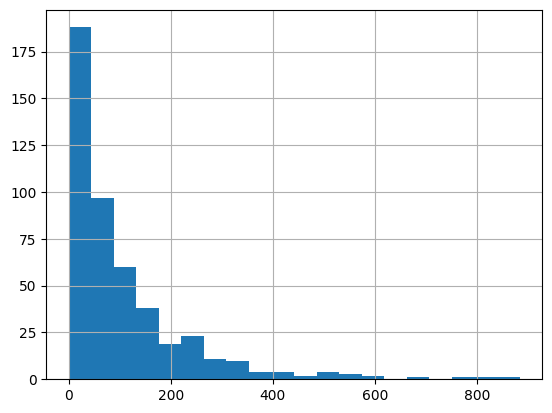

In [91]:
print(f"{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

# Completely Random Shuffle

In [92]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [93]:
existing_cards = existing_cards.sort_values('age', ascending=False)
remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
existing_cards.head(10)

Cards found: 469


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll
0,Open Source/GitHub,Semantic Versioning\n\nA versioning scheme tha...,9aef26d41b1623fdd93eaeef436024ea,883.137303,112.376909,883.137303,2584.668911,0.119462
6,Email Auth and Security,DKIM (DomainKeys Identified Mail)\n\nAn email ...,991e90ea49a5db4146ebabcbdc7fe747,811.712962,207.329742,811.712962,3524.605613,0.114860
12,Powershell,Start-Service\nStarts a Windows service by nam...,678b4e19869c1a72f5aa179b6733ec92,792.080152,193.748560,792.080152,4068.719752,0.253061
18,Azure Kubernetes Learning Path,Container storage drives are less performant.\...,e80bac6173d1eda951fa9c29694509c9,674.913925,198.941342,674.913925,3183.061467,0.417149
13,Powershell,-ArgumentList\nSpecifies parameters to pass to...,d81ba862baa460ca56623d52296215bf,586.616472,193.748560,792.080152,4068.719752,0.253061
24,Azure AI Foundry,Connections let you access objects in AI Found...,6e6d4173055ade852de68040477ae613,579.835161,196.815050,579.835161,2755.410701,0.262047
30,DNS,DNS Forwarders\nDNS servers configured to forw...,f463f6cb9a7ce6b8e8b7342524163dac,571.558118,122.069281,571.558118,2319.316343,0.769838
14,Powershell,"New-Item\nCreates new files, directories, or r...",d5111ff980245d2b930bd9b4a51480b0,552.126175,193.748560,792.080152,4068.719752,0.253061
36,OData,Complex Types are structured data types in ODa...,110c6e6e6d9effc60ebfc5f00ec5da7f,544.602111,178.992358,544.602111,3579.847157,0.070987
7,Email Auth and Security,DMARC Analyzer\n\nA tool that helps organizati...,dba5d176e6856fc687767d9fcfd83d1c,509.501779,207.329742,811.712962,3524.605613,0.114860


# Headers with fewest notes first

In [94]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# existing_cards.head(10)

# Focus on one header

In [95]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Header with oldest cards first

In [96]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest mean card age first

In [97]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest age sum first

In [98]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle

## Random

In [99]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

## Age Sum

In [100]:
# n=4
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)
# existing_cards.head(10)

# remake_card_document(existing_cards=existing_cards)

## Age max

In [101]:
# n = 6
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [102]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)



## Card Count

In [103]:
# n=3
# existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'frequency', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)



In [104]:
existing_cards.head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll
0,Open Source/GitHub,Semantic Versioning\n\nA versioning scheme tha...,9aef26d41b1623fdd93eaeef436024ea,883.137303,112.376909,883.137303,2584.668911,0.119462
6,Email Auth and Security,DKIM (DomainKeys Identified Mail)\n\nAn email ...,991e90ea49a5db4146ebabcbdc7fe747,811.712962,207.329742,811.712962,3524.605613,0.114860
12,Powershell,Start-Service\nStarts a Windows service by nam...,678b4e19869c1a72f5aa179b6733ec92,792.080152,193.748560,792.080152,4068.719752,0.253061
18,Azure Kubernetes Learning Path,Container storage drives are less performant.\...,e80bac6173d1eda951fa9c29694509c9,674.913925,198.941342,674.913925,3183.061467,0.417149
13,Powershell,-ArgumentList\nSpecifies parameters to pass to...,d81ba862baa460ca56623d52296215bf,586.616472,193.748560,792.080152,4068.719752,0.253061
24,Azure AI Foundry,Connections let you access objects in AI Found...,6e6d4173055ade852de68040477ae613,579.835161,196.815050,579.835161,2755.410701,0.262047
30,DNS,DNS Forwarders\nDNS servers configured to forw...,f463f6cb9a7ce6b8e8b7342524163dac,571.558118,122.069281,571.558118,2319.316343,0.769838
14,Powershell,"New-Item\nCreates new files, directories, or r...",d5111ff980245d2b930bd9b4a51480b0,552.126175,193.748560,792.080152,4068.719752,0.253061
36,OData,Complex Types are structured data types in ODa...,110c6e6e6d9effc60ebfc5f00ec5da7f,544.602111,178.992358,544.602111,3579.847157,0.070987
7,Email Auth and Security,DMARC Analyzer\n\nA tool that helps organizati...,dba5d176e6856fc687767d9fcfd83d1c,509.501779,207.329742,811.712962,3524.605613,0.114860


In [105]:
existing_cards.head(10)['age'].sum()

6506.084157396639